In [1]:
import os
import torch
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import random
import full_net
import dataset as MOFdata

def loss_fn(output, target):
    return nn.functional.l1_loss(output, target)
    # diff = torch.abs(output-target)
    # return torch.mean(torch.max(diff, diff**3))
    # return max(nn.functional.l1_loss(output, target), torch.mean(torch.abs(output-target)**3))

# define the LightningModule
class ModulePL(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = full_net.BasicModel(4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = loss_fn(y.float(), y_hat.squeeze())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.model(x)
        loss = loss_fn(y.float(), y_hat.squeeze())
        l1_loss = nn.functional.l1_loss(y.float(), y_hat.squeeze())

        self.log('validation_loss', loss)
        self.log('validation_l1_loss', l1_loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-6, amsgrad=True)
        return optimizer


autoencoder = ModulePL()

In [3]:
import numpy as np

def filter_data(x):
    a, b = -4000, 4000
    mid = (a+b)/2
    dif = b-a
    return np.clip(x, a, b) / dif / 2 - (mid/dif)
    # sigmoid
    # return 1/(1 + np.exp(-np.clip(x, -32, 32)))

grid_file = "grids.npy"
link_file = "grids.link"
csv_file = "ASR.csv"
feature = "LCD"

dataset = MOFdata.Dataset(grid_file, link_file, csv_file, feature, filter_data)
train_set_size = int(.9 * len(dataset))
validation_set_size = int(.05 * len(dataset))
test_set_size = len(dataset) - train_set_size - validation_set_size
train_set, validation_set, test_set = random_split(
    dataset=dataset,
    lengths=(train_set_size,
    validation_set_size,
    test_set_size),
    generator=torch.Generator().manual_seed(42))

loader_args = dict(batch_size=64, num_workers=4)
train_loader = DataLoader(train_set, **loader_args)
validation_loader = DataLoader(validation_set, **loader_args)
test_loader = DataLoader(test_set, **loader_args)

chkpt_dir = "./basic_chkpts"
# first, label = dataset[0]
# print(label)
# plt.imshow(first.reshape(28, 28))

FileNotFoundError: [Errno 2] No such file or directory: 'grids.npy'

In [ ]:
wandb_logger = WandbLogger(project="wide-net")
checkpoint_callback = ModelCheckpoint(dirpath=chkpt_dir, save_top_k=5, monitor="validation_l1_loss")
trainer = pl.Trainer(
    logger = wandb_logger,
    limit_train_batches=100,
    limit_val_batches=10,
    max_epochs=200,
    accelerator='gpu',
    callbacks=[checkpoint_callback],
)
trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=validation_loader)

In [7]:
import os

# load checkpoint
checkpoint = sorted([os.path.join(chkpt_dir, file) for file in os.listdir(chkpt_dir)], key=lambda x: os.path.getmtime(x), reverse=True)[0]
print("reading checkpoint", checkpoint)

model = ModulePL.load_from_checkpoint(checkpoint)

model = model.model.cpu().eval()

ratio_off_mean = 0
runs = 0
worst = 0
worst_absolute = 0
for data_x, data_y in validation_loader:
    pred_y = model(data_x)
    for p, d in zip(pred_y.squeeze(), data_y):
        worst_absolute = max(worst_absolute, abs(p-d).item())
        r = abs(p.item() / d.item())
        r = max(r, 1/r)
        if r > worst:
            worst = r
        ratio_off_mean += r
        runs += 1
print(ratio_off_mean/runs, worst, worst_absolute)

reading checkpoint ./basic_chkpts/epoch=209-step=21000.ckpt
1.1903732598762253 1.8445035640905103 12.887811625366211


In [8]:

def predict(model, loader, count):
    correct = []
    predictions = []
    for data_x, data_y in loader:
        pred_y = model(data_x)
        for p, d in zip(pred_y.squeeze(), data_y):
            correct.append(p.item())
            predictions.append(d.item())
            count -= 1
        if count <= 0:
            break
    return predictions, correct

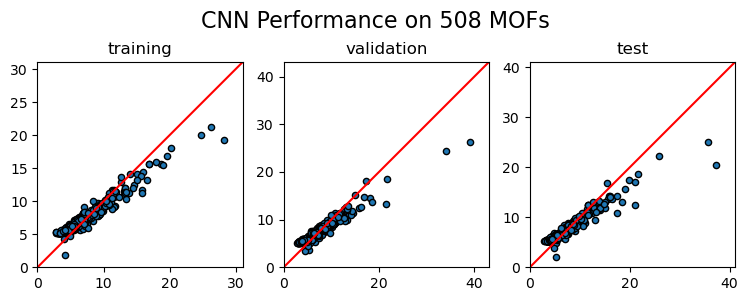

In [9]:
# plot performance

count = min(1024, test_set_size)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
fig.suptitle(f"CNN Performance on {count} MOFs", fontsize=16, verticalalignment='center')

for i, (title, loader) in enumerate(zip(("training", "validation", "test"), (train_loader, validation_loader, test_loader))):
    ax = axs[i]
    x, x_hat = predict(model, loader, count)
    lim = [0, max(*x, *x_hat)*1.1]
    ax.scatter(x, x_hat, s=20, linewidths=1, edgecolors='black')

    ax.title.set_text(title)
    ax.set_aspect('equal')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    # plt.xscale('log')
    # plt.yscale('log')
    ax.plot([0, lim[1]], [0, lim[1]], color='red')

plt.show()